# Final Project (Parts I and II)
### Adam Lowet

My project seeks to explore the structure of resting-state brain activity. Some work has been done that focuses on individual _differences_ between subjects, using their functional connectomes as a "fingerprint" by which to identify subjects and predict cognitive variables such as fluid intelligence (Finn et al., 2015) or sustained attention (Rosenberg et al., 2016).

This study is motivated by the possibility that such differences mask underlying dynamics that are shared among subjects. In particular, it is possible that the brains of _all_ subjects tend to cycle through certain prototypical "states" or "modules" (or "attractors", in dynamical systems terminology). Individual differences could then result from different usage frequencies of each state, or different transition probabilities between states.

Because resting-state scans do not impose structure on neural dynamics, any such states (if they exist) must be determined empirically from brain data. In this study, I use two different clustering algorithms -- affinity propagation, which does not require the number of clusters to be specified _a priori_, and k-means, which does -- to partition functional connectivity data or BOLD data into clusters. It turns out that functional connectivity data, whether defined over anatomical parcels or raw voxels, tends to not share clusters between subjects, adding further support to the notion of a functional connectome fingerprint. By contrast, BOLD activity shares much greater similarity between subjects, such that clusters tend to cut across subjects. This allows such data to conceived as a Markov Model, with a Transition Probability Matrix (TPM) defined for each subject. Statistical analysis of these TPMs reveals striking, subject-specific differences.

The outline of this project is as follows:

I. General setup<br/>
> 1.Preprocess the data<br/>
> 2.Define utility functions<br/>

II. Parcelwise analyses<br/>
> 3.Perform an anatomical parcellation and compute regional connectivity<br/>
> 4.Cluster over regional connectivity<br/>

III. Voxelwise analyses<br/>
> 5.Load in the data voxelwise<br/>
> 6.Perform FCMA and Cluster<br/>
> 7.Visualize the BOLD data in PCA space<br/>
> 8.Cluster BOLD Activity<br/>

IV. Markov Modeling<br/>
> 9.Calculate Transition Probability Matrices<br/>
> 10.Compute statistics over TPMs<br/>

# I. General setup
## 1. Preprocess the data

On the command line, I entered

    Feat &

In the GUI, I modified the following presets as specified:

> Slice timing correction: Interleaved<br/>
> Smoothing: 3mm<br/>
> Standard Motion Parameters<br/>
> Full Model Setup (Basic shape: Empty)<br/>
> Create time series plots: Unchecked<br/>
> High-pass filtering: 1000s<br/>

Subjects' functional scans aligned to their anatomical scans (modified using 3dSkullStrip in AFNI) with 6 DOF, and then standardized into MNI-152 space with 12 DOF.

## 2. Define utility functions

In [1]:
import numpy as np
from math import ceil
import nibabel as nib
import os
import time
import random
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
import scipy.stats
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.util import compute_correlation
from brainiak import io
from itertools import cycle

mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.resample'] = False

In [10]:
# define some utility functions
def compute_correlation_matrices(in_array, n, take_every=1, plot=False, plot_label='Voxel'):
    
    if plot:
        fig, axs = plt.subplots(2,n//2, figsize=(15, 15))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
    
    n_voxels = ceil(in_array[0].shape[1]/take_every)
    out_array = np.zeros((n_voxels, n_voxels, n))
    for i in range(n):

        #extract data for one subject, for one epoch
        data=in_array[i][:,::take_every].T
        #print(data.shape)

        # Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
        mat = np.ascontiguousarray(data, dtype=np.float32)

        # Voxels X TRs for one epoch
        begin_time = time.time()
        epoch_corr=compute_correlation(mat, mat)
        end_time = time.time()
        #print("Analysis duration: %0.5fs" % (end_time - begin_time))
        
        out_array[:,:,i] = np.triu(epoch_corr)
        
        if plot:
            # Remove the diagonal for visualization (guaranteed to be 1.0)
            np.fill_diagonal(epoch_corr, np.nan)
            im = axs[i].imshow(epoch_corr)
            axs[i].set_title('Correlations for Subject ' + str(ppt+i))
            axs[i].set_xlabel(plot_label)
            axs[i].set_ylabel(plot_label)
    
    if plot:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.show()
        
    return out_array

def compute_sliding_correlation_matrices(in_array, TR_window, step, n_TR, take_every):

    n_steps = 1 + (n_TR-TR_window)//step #(n_TR+1-TR_window)//step
    n_voxels = ceil(in_array[0].shape[1]/take_every)
    out_array = np.zeros((n_steps*n_subj, ((n_voxels**2-n_voxels)//2)))

    for i in range(n_subj):
        
        #extract data for one subject, for one epoch (take only the every "take_every"th voxel)
        sub_data=in_array[i][:,::take_every].T
        print(sub_data.shape)
        
        for j in range(n_steps):

            window_data = sub_data[:,j*step:(j*step)+TR_window]

            # Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
            mat = np.ascontiguousarray(window_data, dtype=np.float32)

            # Voxels X TRs for one epoch
            epoch_corr=compute_correlation(mat, mat)        
            epoch_corr_vector = epoch_corr[np.triu_indices(epoch_corr.shape[0], k=1)]

            #store vectors as row in array
            out_array[j+(n_steps*i),:] = epoch_corr_vector
    
    return out_array

In [3]:
def affinity_prop(concatenated_data, plot=True, title_string=''):
    
    # Compute Affinity Propagation
    af = AffinityPropagation(max_iter=10000).fit(concatenated_data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters = len(cluster_centers_indices)
    sil_score = metrics.silhouette_score(concatenated_data, labels, metric='sqeuclidean')

    print('Estimated number of clusters: %d' % n_clusters)
    print("Silhouette Coefficient: %0.3f" % sil_score)

    # #############################################################################
    # Plot result
    
    if plot:
        plt.figure()
        plt.clf()

        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters), colors):
            class_members = labels == k
            cluster_center = concatenated_data[cluster_centers_indices[k]]
            plt.plot(concatenated_data[class_members, 0], concatenated_data[class_members, 1], col + '.')
            plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
            for x in concatenated_data[class_members]:
                plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

        plt.title('Estimated number of clusters: %d' % n_clusters)
        plt.show()
        
        plt.figure()
        plt.plot(labels)
        n_TR_subj = concatenated_data.shape[0]//n_subj
        for i in range(1, n_subj+1):
            plt.axvline(x=i*n_TR_subj, ls='--', c='g')
        plt.xlabel('TR')
        plt.ylabel('Cluster')
        plt.title('Affinity Propagation Clusters over ' + title_string + ' Data')
    
    return {'prototypes':cluster_centers_indices,
            'labels': labels,
            'n_clusters': n_clusters,
            'score': sil_score}

def k_mean(in_array, n, plot=True, title_string=''):
    
    kmean = KMeans(n_clusters=n)
    kmean_results = kmean.fit(in_array)
    kmean_labels = kmean_results.labels_
    
    if plot:
        plt.figure()
        plt.plot(kmean_labels)
        n_TR_subj = in_array.shape[0]//n_subj
        for i in range(1, n_subj+1):
            plt.axvline(x=i*n_TR_subj, ls='--', c='g')
        plt.xlabel('TR')
        plt.ylabel('Cluster')
        plt.title('k-Means Clusters over ' + title_string + ' Data')
    
    return kmean_labels

In [4]:
def z_score(in_array, high_pass=None, across_time=True, across_space=False):
    
    z_scored = in_array
    print(z_scored.shape)
    
    #do high-pass filtering on each time series of voxels
    if high_pass is not None:
        
        def butter_highpass(cutoff, fs, order=5):
            nyq = 0.5 * fs
            normal_cutoff = cutoff / nyq
            b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
            return b, a

        def butter_highpass_filter(data, cutoff=1/high_pass, fs=1/TR_duration, order=5):
            b, a = butter_highpass(cutoff, fs, order=order)
            y = signal.filtfilt(b, a, data)
            return y
    
        z_scored = np.apply_along_axis(butter_highpass_filter, axis=0, arr=z_scored)
    
    #z-score across time
    if across_time:
        #z-score each voxel across time
        scaler = preprocessing.StandardScaler().fit(z_scored)
        z_scored =  scaler.transform(z_scored)
    
    #z-score across space (part of trying to get clustering to work)
    if across_space:
        z_scored = z_scored.T
        scaler = preprocessing.StandardScaler().fit(z_scored)
        z_scored =  scaler.transform(z_scored)
        z_scored = z_scored.T
    
    return z_scored

# II. Parcelwise analyses
## 3. Perform an anatomical parcellation and compute regional connectivity

Although the brains are already in MNI coordinates, there is no reason that the same voxel must be doing the same thing in all subjects. To get around this, I will parcellate over the entire brain (cortical and subcortical regions) and then compute correlation matrices, following Finn et al., 2015, to get each subject's functional connectome.

In [5]:
dir = '/gpfs/milgram/scratch/cmhn-s18/asl65/cmhn-s18-wk12-final-adamlowet/'
ppt = 105
n_subj = 8
n_TR = 132
TR_duration = 2.5
random.seed(1)

#use the 268-region whole-brain parcellation from Shen et al., 2013 
atlas_filename = dir + 'shen_2mm_268_parcellation.nii.gz'
atlas_img = nib.load(atlas_filename)
atlas = NiftiLabelsMasker(labels_img=atlas_filename, resampling_target='labels')
atlas_array = []

for sub in range(ppt, ppt+n_subj):
    
    epi_in = (dir + 'wash120/sub-%03d/func/sub-%03d-new.feat/stats/res4d.nii.gz' % (sub, sub))
    epi_data = nib.load(epi_in)
        
    parcel_time_series = atlas.fit_transform(epi_data)
    parcel_time_series = z_score(parcel_time_series, high_pass=None, across_time=True, across_space=False)
        
    print("Parcellated dimensionality: %d timepoints by %d ROIs" % parcel_time_series.shape)
    #print(np.mean(parcel_time_series[:,0])) #should be equal to 0
    
    atlas_array.append(parcel_time_series)

print(atlas_array[0].shape)

(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)
Parcellated dimensionality: 132 timepoints by 268 ROIs
(132, 268)


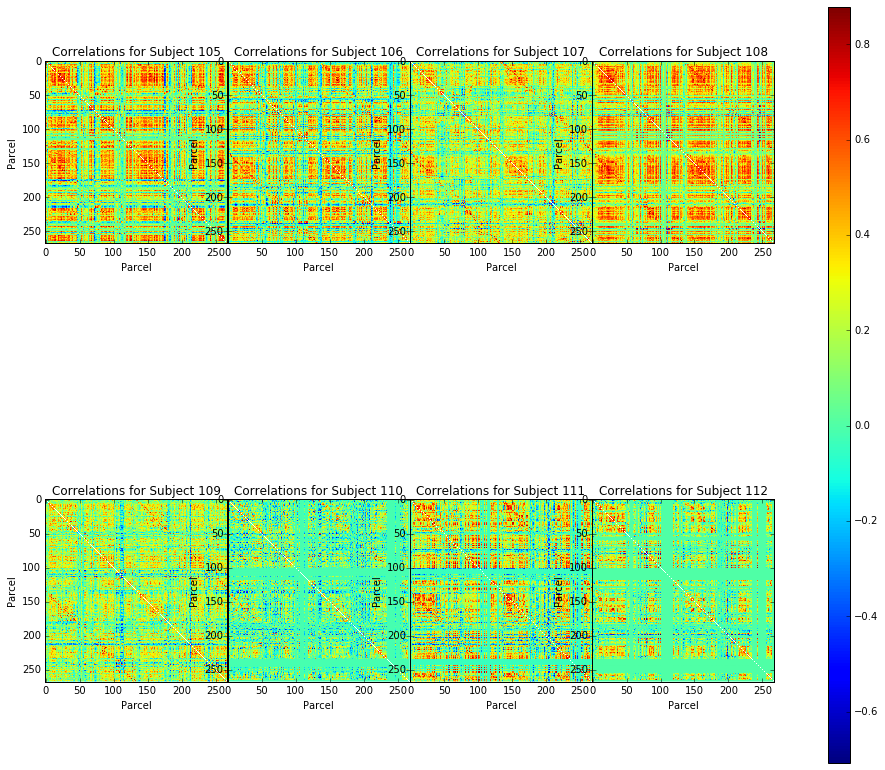

(268, 268, 8)


In [11]:
atlas_corr_array = compute_correlation_matrices(atlas_array, n=n_subj, plot='True', plot_label='Parcel')
print(atlas_corr_array.shape)

## 4. Cluster over regional connectivity
I want to cluster each time slice, but the correlation matrices computed above give me only one "summary functional connectome" for each subject. To get a picture of how the functional connectome changes over the duration of the scan, here I slide a window of 10 TRs over the entire 132 TR-long scan. I then vectorize each of these correlation matrices, concatenate them across subjects, and cluster.

In [12]:
rolling_atlas_corr_array = compute_sliding_correlation_matrices(atlas_array, TR_window=10, step=1, n_TR=132, take_every=1)
print(rolling_atlas_corr_array.shape)

#z-score each time slice across space
#rolling_atlas_corr_array_stand = z_score(rolling_atlas_corr_array, across_time=False, across_space=True)

(268, 132)
(268, 132)
(268, 132)
(268, 132)
(268, 132)
(268, 132)
(268, 132)
(268, 132)
(984, 35778)


Estimated number of clusters: 149
Silhouette Coefficient: 0.504


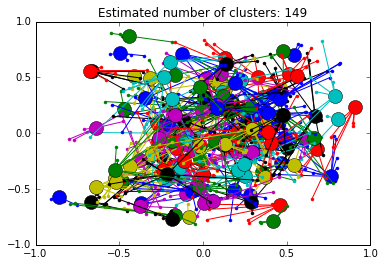

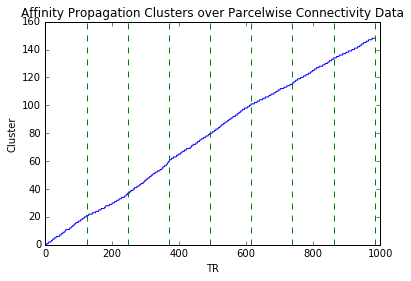

In [13]:
#print(rolling_atlas_corr_array_stand.shape)
rolling_atlas_corr_clusters = affinity_prop(rolling_atlas_corr_array, title_string='Parcelwise Connectivity') #_stand)

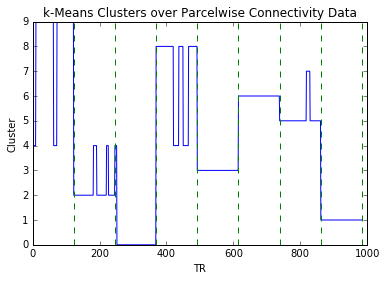

In [14]:
#We can try k-means instead to force fewer clusters, then see if these
#clusters cut across subjects
rolling_atlas_corr_k_labels = k_mean(rolling_atlas_corr_array, 10, title_string='Parcelwise Connectivity')

From the above plots, we can see that in functional connectivity space, indidual subjects use only a handful of possible clusters. Indeed, in the case of affinity propagation, no cluster is re-used by multiple subjects. This indicates that each subject has a unique connectome "fingerprint" that distinguishes them from all other subjects.